import modules

In [1]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence, dist, dim_specific_MSE, dim_specific_dist, distV2
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


set device

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate dataset

In [3]:
grid = t.zeros((2, 30, 30), device=device)
grid[:] = 50
grid[0, 12:17] = 90

gamma = 0.005
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 100
num_steps = 1_000
DA = 0.1
DB = 0.4

sequence = generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
)
dataset = chop_and_shuffle_data(sequence, shuffle=True)
if device == "cuda":
    dataset.cuda()
print(f"created dataset with shape: {dataset.shape}")


  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 1000/1000 [00:07<00:00, 128.88it/s]

created dataset with shape: torch.Size([999, 2, 2, 30, 30])


visualize distance and gradients for k1 when varying other coefficients

In [6]:
# we use the original DA and DB values
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
# split the dataset for usage
X = dataset[:,0]
Y_obs = dataset[:,1]
# rate coefficient ranges
k1_vals = t.linspace(0.0001, 0.9999, 100)
k2_vals = t.linspace(0.0001, 0.9999, 10)

# we use the original rate coefficients for the other reaction channels
k1_bar = t.tensor(0.98, device=device)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)


# collect the results of each test run here
grad_means_k1 = []
distances = []
for k2 in k2_vals:
    for k1 in tqdm(k1_vals):
        # collect the results of the current test run
        distances_current_run = []
        grad_k1_current_run = []
        # For each DA value, we simulate and backpropagate 2 times,
        # averaging the distance and the gradient of each run
        for run in range(10):
            k1.requires_grad_()
            # 1. run the diffusion step on each sample
            diffused_samples = diffuse_STE(X, N, DA, DB)
            # 2. run the reaction step on each sample
            Y_sim = rho_STE(diffused_samples, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
            # use the sum of dim-specific distances
            dist_val = distV2(X, Y_sim, Y_obs)
            distances_current_run.append(dist_val.detach().cpu().numpy())
            grad_k1 = t.autograd.grad(dist_val, k1)[0]
            grad_k1_current_run.append(grad_k1.detach().cpu().numpy())
        distances.append(np.mean(distances_current_run))
        grad_means_k1.append(np.mean(grad_k1_current_run))

100%|██████████| 100/100 [06:56<00:00,  4.16s/it]


<Figure size 640x480 with 0 Axes>

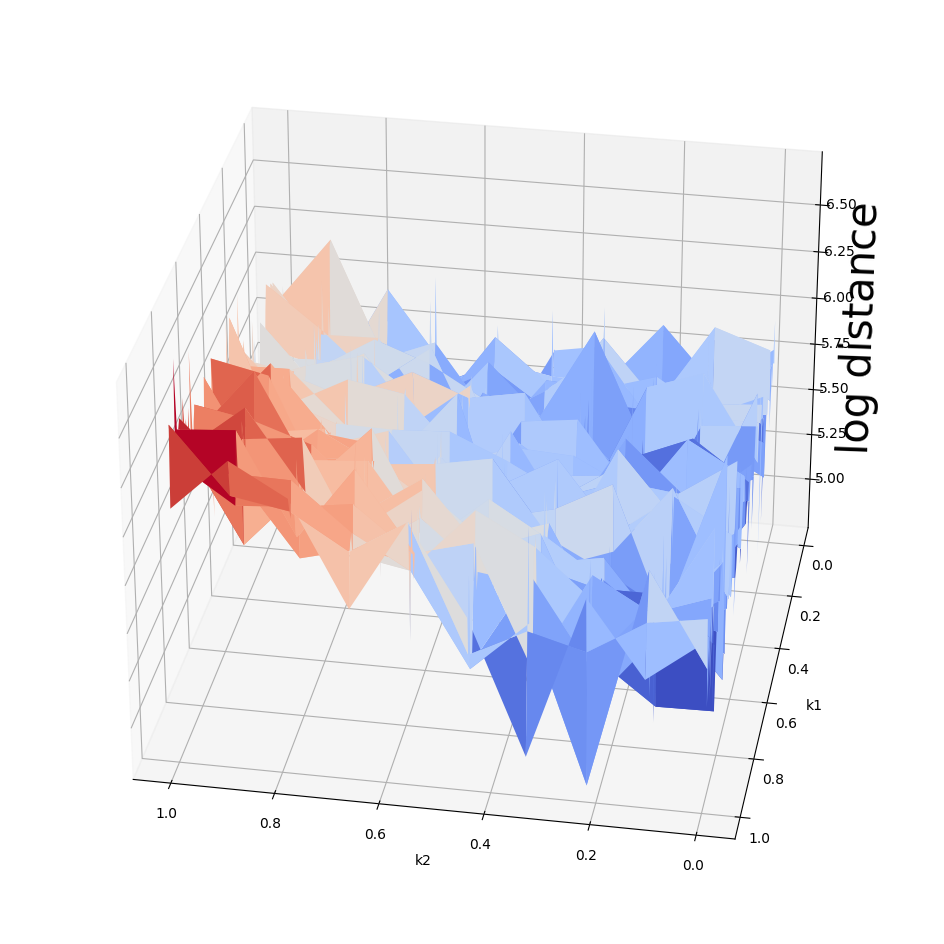

<Figure size 640x480 with 0 Axes>

In [19]:
from matplotlib import cm
from matplotlib import rcParams

grid_k2, grid_k1 = t.meshgrid(k2_vals, k1_vals, indexing="ij")

fig, ax = plt.subplots(subplot_kw={"projection": "3d", "computed_zorder": False}, figsize=(12,12))
ax.plot_surface(grid_k2.cpu(), grid_k1.cpu(), np.log(np.array(distances)).reshape(10,100), cmap=cm.coolwarm)
ax.set(xlabel="k2", ylabel="k1") 
ax.set_zlabel('log distance', fontsize=30, rotation = 0, position=(10,10))

ax.view_init(30, 100)

plt.figure(constrained_layout=True)

In [20]:
# we use the original DA and DB values
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
# split the dataset for usage
X = dataset[:,0]
Y_obs = dataset[:,1]
# rate coefficient ranges
k1_vals = t.linspace(0.0001, 0.9999, 100)
k3_vals = t.linspace(0.0001, 0.9999, 10)

# we use the original rate coefficients for the other reaction channels
k1_bar = t.tensor(0.98, device=device)
k2 = t.tensor(0.1, device=device)
k2_bar = t.tensor(0.1, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.005, device=device)

grid_k1, grid_k3 = t.meshgrid(k1_vals, k3_vals, indexing="ij")


# collect the results of each test run here
grads_k1 = []
distances = []
for i in range(k1_vals.shape[0]):
    for j in tqdm(range(k2_vals.shape[0])):
        k1 = grid_k1[i,j]
        k3 = grid_k3[i,j]
        k1.requires_grad_()
        # 1. run the diffusion step on each sample
        diffused_samples = diffuse_STE(X, N, DA, DB)
        # 2. run the reaction step on each sample
        Y_sim = rho_STE(diffused_samples, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
        # use the sum of dim-specific distances
        dist_val = distV2(X, Y_sim, Y_obs)
        distances.append(dist_val.detach().cpu().numpy())
        grad_k1 = t.autograd.grad(dist_val, k1)[0]
        grads_k1.append(grad_k1.detach().cpu().numpy())

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


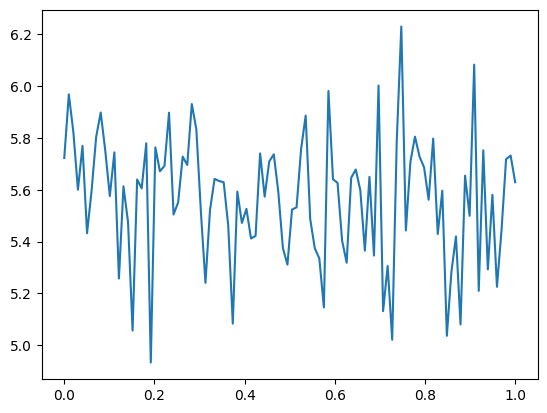

In [7]:
plt.plot(k1_vals.cpu(), np.log(np.array(distances)[:100]))
plt.plot(k1_vals.cpu())